<!-- https://www.quantifiedstrategies.com/pairs-trading-strategy-python/ -->

# Notebook Pairs Trading

In [1]:
# Importanto bibliotecas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

plt.style.use('bmh')

In [2]:
def baixando_dados(inicio, fim, tick1, tick2):
    ativo1 = yf.download(tick1, start=inicio, end=fim)
    ativo2 = yf.download(tick2, start=inicio, end=fim)

    ativo1_relativo = ativo1['Close']/ativo1['Close'].iloc[0] * 100
    ativo2_relativo = ativo2['Close']/ativo2['Close'].iloc[0] * 100
    
    return ativo1, ativo2, ativo1_relativo, ativo2_relativo

In [3]:
ativo1, ativo2, ativo1_relativo, ativo2_relativo = baixando_dados(inicio = '2020-01-01', fim = '2022-12-31', tick1 = 'TRPL4.SA', tick2 = 'EGIE3.SA')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


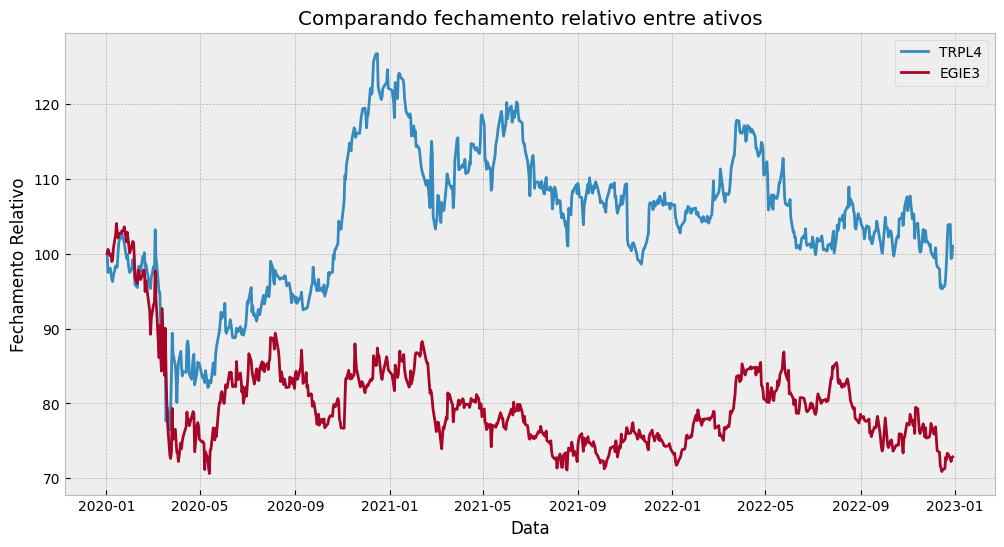

In [4]:
# Comparando fechamento relativo entre ativos
plt.figure(figsize=(12,6))
plt.title('Comparando fechamento relativo entre ativos')
plt.plot(ativo1_relativo, label='TRPL4')
plt.plot(ativo2_relativo, label='EGIE3')
plt.xlabel('Data')
plt.ylabel('Fechamento Relativo')
plt.legend()
plt.savefig('ativos_arbitragem.png')

In [5]:
def gerando_residuos(dados_y, dados_x):
    Y = np.log(dados_y)
    X = np.log(dados_x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    results.params

    alpha = results.params.values[0]
    beta = results.params.values[1]
    errors = Y - (alpha + X['Close']*beta)
    return alpha, beta, errors

In [6]:
alpha, beta, errors = gerando_residuos(dados_y = ativo2['Close'], dados_x = ativo1['Close'])

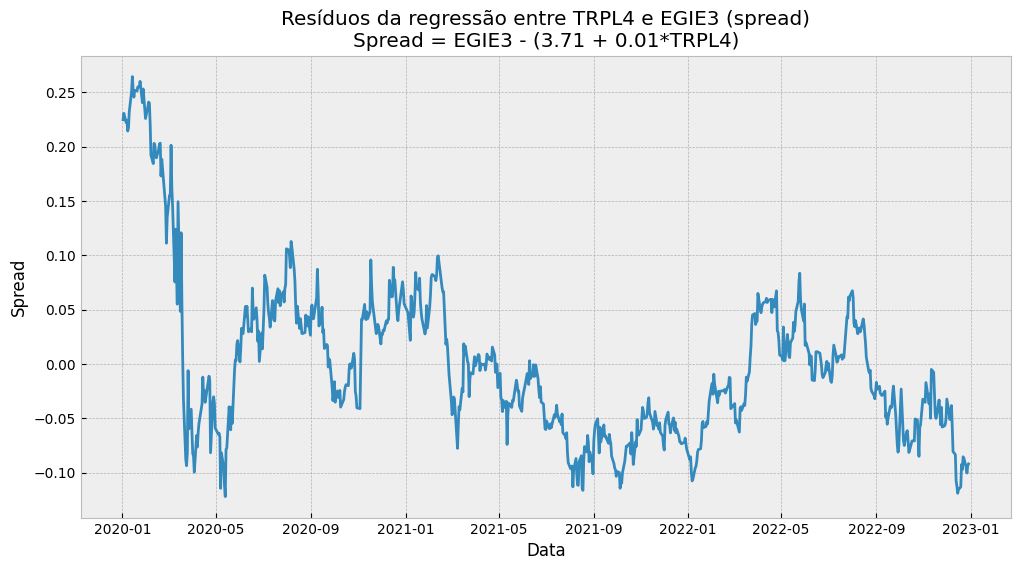

In [7]:
# Observando os resíduos
plt.figure(figsize=(12,6))
plt.title(f'Resíduos da regressão entre TRPL4 e EGIE3 (spread)\nSpread = EGIE3 - ({alpha:.2f} + {beta:.2f}*TRPL4)')
plt.plot(errors)
plt.xlabel('Data')
plt.ylabel('Spread')
plt.savefig('residuos.png')

In [8]:
def teste_adfuller(dados, lag):
    dftest = adfuller(dados, maxlag=lag)
    dfoutput = pd.DataFrame(data={'Valores': dftest[0:4]}, index=['Teste Estatístico', 'p-valor', 'Lag usado', 'Nº observações'])
    critical_values = pd.DataFrame(data={'Valores': dftest[4].values()}, index=dftest[4].keys())
    
    print('Teste estatístico:')
    display(dfoutput)
    display(critical_values)

In [10]:
teste_adfuller(dados = errors, lag = 1)

Teste estatístico:


,Valores
Teste Estatístico,-3.285210
p-valor,0.015553
Lag usado,1.000000
Nº observações,743.000000


,Valores
1%,-3.439182
5%,-2.865438
10%,-2.568846


In [11]:
def gerando_zscore(dados):
    return (dados - np.mean(dados)) / np.std(dados)

In [12]:
zscore = gerando_zscore(dados = errors)

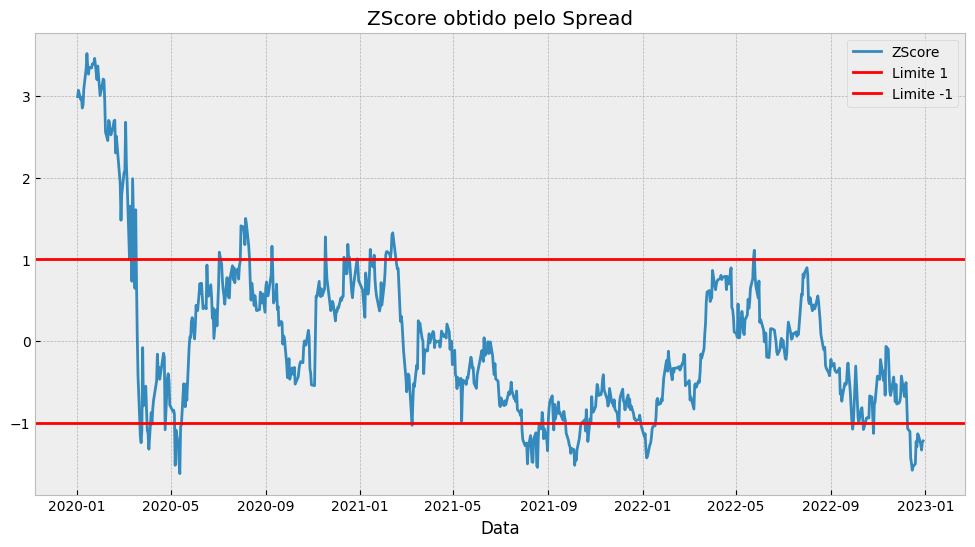

In [13]:
# Observando ZScore
plt.figure(figsize=(12,6))
plt.title('ZScore obtido pelo Spread')
plt.plot(zscore, label='ZScore')
plt.axhline(y=1, color='red', label='Limite 1')
plt.axhline(y=-1, color='red', label='Limite -1')
plt.xlabel('Data')
plt.legend()
plt.savefig('zscore.png')

In [14]:
def algo_arbitragem(entrada, saida, ativo1, ativo2, zscore):
    btest = pd.DataFrame()
    btest['ativo2'] = ativo2['Close']
    btest['ativo1'] = ativo1['Close']
    btest['sinal venda'] = (zscore > entrada) & (zscore.shift(1) < entrada)
    btest['saida venda'] = (zscore < saida) & (zscore.shift(1) > saida)

    btest['sinal compra'] = (zscore < -entrada) & (zscore.shift(1) > -entrada)
    btest['saida compra'] = (zscore > -saida) & (zscore.shift(1) < -saida)
    return btest

In [15]:
btest = algo_arbitragem(entrada = 1, saida = 0, ativo1 = ativo1, ativo2 = ativo2, zscore = zscore)

In [16]:
def backtest_arbitragem(dados):
    lado_spread = None
    contador = -1
    backtest_result = []
    indicator = 0

    for tempo, sinal_ativo in dados.iterrows():
        contador+=1
        ativo2_, ativo1_, sinal_venda, saida_venda, sinal_compra, saida_compra = sinal_ativo
        
        if lado_spread == None:
            retorno_ativo2 = 0
            retorno_ativo1 = 0
            backtest_result.append([tempo, retorno_ativo2, retorno_ativo1, lado_spread])
            
            if sinal_venda == True:
                lado_spread = 'venda'
            elif sinal_compra == True:
                lado_spread = 'compra'
                
        elif lado_spread == 'compra':
            retorno_ativo2 = dados['ativo2'].iloc[contador] / dados['ativo2'].iloc[contador -1] -1
            retorno_ativo1 = dados['ativo1'].iloc[contador] / dados['ativo1'].iloc[contador -1] -1
            backtest_result.append([tempo, retorno_ativo2, -retorno_ativo1, lado_spread])
            
            if saida_compra == True:
                lado_spread = None
                
        elif lado_spread == 'venda':
            retorno_ativo2 = dados['ativo2'].iloc[contador] / dados['ativo2'].iloc[contador -1] -1
            retorno_ativo1 = dados['ativo1'].iloc[contador] / dados['ativo1'].iloc[contador -1] -1
            backtest_result.append([tempo, -retorno_ativo2, retorno_ativo1, lado_spread])
            
            if saida_venda == True:
                lado_spread = None
                
    return backtest_result

In [17]:
backtest_result = backtest_arbitragem(dados = btest)

In [18]:
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ['Data', 'ativo2', 'ativo1', 'posicao']
backtest_pandas['ativo2 pl'] = np.cumprod(backtest_pandas['ativo2'] + 1)-1
backtest_pandas['ativo1 pl'] = np.cumprod(backtest_pandas['ativo1'] + 1)-1
backtest_pandas['total pl'] = (backtest_pandas['ativo1 pl'] + backtest_pandas['ativo2 pl']) /2
backtest_pandas.index = backtest_pandas['Data']

In [19]:
# Comparativo IBOVESPA
bench = yf.download(['^BVSP', 'TRPL4.SA', 'EGIE3.SA'], start='2020-01-01', end='2022-12-31')['Close']
bench_ret = bench.pct_change().dropna()
bench_ret_cum = np.cumprod(bench_ret + 1)-1

[*********************100%%**********************]  3 of 3 completed


Retorno acumulado Estratégia Arbitragem: 24.47 %
Retorno acumulado TRPL4: 1.01 %
Retorno acumulado EGIE3: -27.15 %
Retorno acumulado Ibovespa: -7.2 %


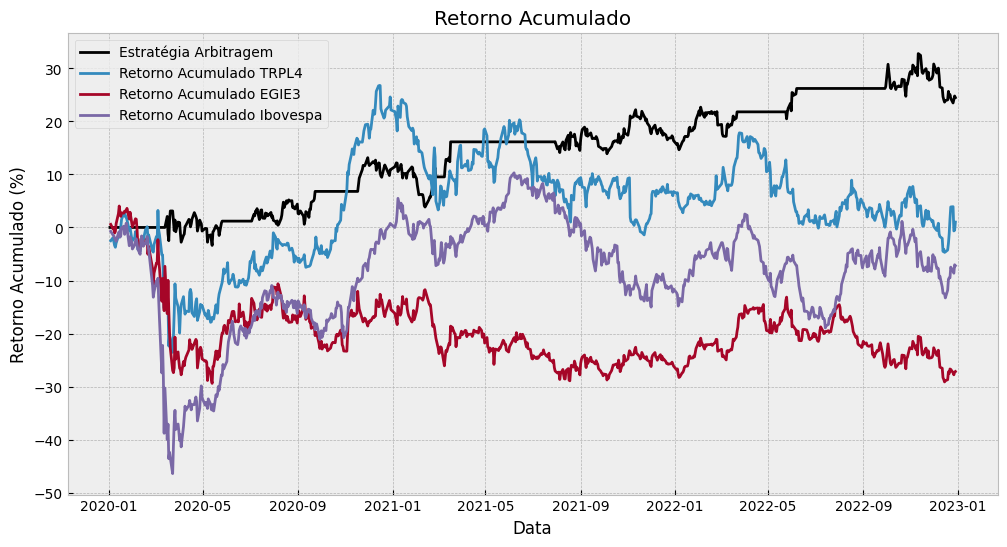

In [20]:
# Visualizando retorno acumulado
plt.figure(figsize=(12,6))
plt.title('Retorno Acumulado')
plt.plot(backtest_pandas[['total pl']]*100, label='Estratégia Arbitragem', color='black')
plt.plot(bench_ret_cum['TRPL4.SA']*100, label='Retorno Acumulado TRPL4')
plt.plot(bench_ret_cum['EGIE3.SA']*100, label='Retorno Acumulado EGIE3')
plt.plot(bench_ret_cum['^BVSP']*100, label='Retorno Acumulado Ibovespa')
plt.legend()
plt.ylabel('Retorno Acumulado (%)')
plt.xlabel('Data')
plt.savefig('backtest.png')

print('Retorno acumulado Estratégia Arbitragem:', np.round(backtest_pandas['total pl'].iloc[-1]*100, 2), '%')
print('Retorno acumulado TRPL4:', np.round(bench_ret_cum['TRPL4.SA'].iloc[-1]*100, 2), '%')
print('Retorno acumulado EGIE3:', np.round(bench_ret_cum['EGIE3.SA'].iloc[-1]*100, 2), '%')
print('Retorno acumulado Ibovespa:', np.round(bench_ret_cum['^BVSP'].iloc[-1]*100, 2), '%')